# Есаян Армен, 2 курс, МатФак ВШЭ
# Кейс по алгоритмическому трейдингу 
 
 В данной работе в качестве финансового инструмента рассматривается пут-опцион на фьючерс на индекс S&P500.
 Решение кейса представляет из себя проверку научной гипотезы О.Бондаренко, описанной в статье "Why are Put Options so Expensive?" (см. по ссылке https://papers.ssrn.com/sol3/papers.cfm?abstract_id=375784). Хотим проверить, что премии за пут-опционы данного базового актива переоценены, и реализовать стратегию, в которой данный базовый актив мы будем шортить.
 
 Решение кейса состоит из трех частей.
 
__Часть 1 (мотивация).__ Рассматривается подразумеваемая волатильность (implied volatility) пут-опционов фьючерса на S&P500 с датой экспирации в сентябре 2021 года, торгующиеся 24 августа 2021 года (файл data.csv, данные взяты с сайта https://www.cmegroup.com/markets/equities/sp/sandp-500.settlements.options.html#optionProductId=135&optionExpiration=135-U1&tradeDate=08%2F24%2F2021).

Взяв опционы со стоимостью страйка +-10% от уровня страйка ATM опциона (для отсечения самых неликвидных), строится график зависимости подразумеваемой волатильности от денежности опциона.

Подразумеваемую волатильность можно найти приближенно, решив уравнение Блэка-Шоулза "наоборот", зная все параметры, кроме, как раз-таки, волатильности. Для этого вычисляется "грек" вега, и при помощи метода Эйлера находится параметр сигма с заранее установленной точностью и максимальным количеством шагов.

Вывод: премии пут-опционов на данный базовый актив переоценены.
 
__Часть 2 (торговая стратегия - код).__ Стратегия, рассматриваемая в данной работе, представляет из себя продажу в шорт пут-опционов при определённом поведении рынка и прекращение трейдинга на некоторое время при достаточно высоких значениях X индекса волатильности S&P VIX. Прекращать шортить фьючерс на S&P при панике на рынке мотивирована высокими рисками и вероятностью того, что рынок поведет себя иррационально, что не учитывается в модели, на которой основана наша стратегия. В каждый момент времени t мы либо покупаем, либо продаем данный базовый актив, то есть мы не докупаемся и не увеличиваем позицию.

  Чистая прибыль, полученная в момент времени t, считается по следующей формуле: 
  
  $$P\&L_{t} = \begin{cases}
S_{t + 1} - K_{t} + Put_{t}; \ \ если \ \  VIX_{t} < X \ и \  S_{t + 1} \leq K_{t} \\
Put_{t}; \ \ если \ \ VIX_{t} < X \ и \ S_{t + 1} > K_{t} \\
0; \ \ если \ \ VIX_{t} \geq X 
\end{cases}$$

где:
* $Put_{t}$ - стоимость премии пут-опциона
* $X$ - пороговое значение индекса VIX
* $K_{t} = S\&P_{t}$ - страйк в момент времени t
* $S_{t+1} = S\&P_{t + 1}$ - стоимость базового актива (уровень индекса S&P500) в момент времени t+1

Разность между t+1 и t - месяц без выходных дней (примерно 25 дней)

Пороговое значение VIX выбирается таким образом, чтобы максимизировать коэффициент Шарпа.

__Часть 3 (бэктестирование)__

Для бэктестирования рассматрены коэффициент Шарпа и отношение накопленной доходности к максимальной просадке.
Построены графики зависимости исторической чистой прибыли для данных в обучающей и тестовой выборке.


__Часть 1.__ 

Импортируем все необходимые библиотеки

In [51]:
#!pip install PrettyTable
#!pip install pandas-datareader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pandas_datareader.data as web  

from scipy.stats import norm
from prettytable import PrettyTable

%matplotlib inline
sns.set(style = "darkgrid")

"data.csv" - данные по опционам с датой экспирацией в сентябре 2021 года

(ссылка: https://www.cmegroup.com/markets/equities/sp/sandp-500.settlements.options.html#optionProductId=135&optionExpiration=135-U1&tradeDate=08%2F24%2F2021)

In [52]:
df1 = pd.read_csv('data.csv', header = 0, delimiter = ";") 

In [53]:
def black(F0, K, T, r, sigma): #Формула Блэка-Шоулза для пут-опционов
    d1 = (np.log(F0 / K) + sigma ** 2 * T / 2) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    put = np.exp(-r * T) * (K * norm.cdf(-d2) - F0 * norm.cdf(-d1))
    return put

def find_vol(target_value, S, K, T, r): #функция приближенно вычисляет подразумеваемую волатильность при помощи
    MAX_ITERATIONS = 500                #метода Эйлера
    PRECISION = 1.0e-5
    sigma = 0.5
    for i in range(MAX_ITERATIONS):
        price = black(S, K, T, r, sigma)
        vega = vega_calc(S, K, T, r, sigma)
        diff = target_value - price  
        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma + diff/vega
    return sigma # возвращается приближенное значение подразумеваемой волатильности 

def vega_calc(F0, K, T, r, sigma): #вычисляется "грек" вега 
    d1 = (np.log(F0 / K) + sigma ** 2 * T / 2) / (sigma * np.sqrt(T))
    vega = F0 * norm.pdf(d1, 0.0, 1.0) * np.sqrt(T)
    return vega

F0 = 4482.50 #текущий уровень индекса S&P500
r = 0.00013 #безрисковская процентная ставка ~0.04% на 3 месяца
         # https://www.bloomberg.com/markets/rates-bonds/government-bonds/us
T1 = 25/252 #время, оставшееся до экспирации опциона

In [54]:
df1 = df1[(F0 * 0.9 < df1['Strike Price']) & (F0 * 1.1>= df1['Strike Price'])] #убираем самые неликвидные продукты

In [55]:
implieds = np.zeros(len(df1))

for i in range(len(df1)):
    implieds[i] = find_vol(df1['Put Price'].iloc[i], F0, df1['Strike Price'].iloc[i], T1, r)
    
df1['IV'] = implieds
df1

,Call Price,Strike Price,Put Price,IV
123,448.30,4040,15.6,0.254353
124,438.70,4050,16.1,0.251952
125,429.20,4060,16.5,0.249056
126,419.70,4070,17.0,0.246503
127,410.20,4080,17.6,0.244265
...,...,...,...,...
208,0.35,4870,397.6,0.187856
209,0.30,4880,407.6,0.191314
210,0.30,4890,417.6,0.194750
211,0.25,4900,427.5,0.197694


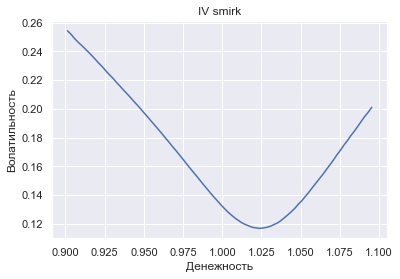

In [56]:
plt.title('IV smirk')

plt.plot(df1['Strike Price'] / F0, df1['IV'])

plt.ylabel('Волатильность')
plt.xlabel('Денежность')

plt.show()

Судя по графику зависимости подразумеваемой волатильности от денежности базового актива, можно сделать вывод, что АТМ-путы стоят дороже, чем должны. Они менее волатильны, следовательно, должны стоить дешевле (следует из формулы Блэка-Шоулза), чем в данный момент на рынке. Поэтому они переоценены, и стратегия шортить фьючерс на S&P аргументирована.

__Часть 2.__ 

Подготовим данные для обучения

In [57]:
start = dt.datetime(2010, 1, 1) #начальная дата - начало 2010 года
end = dt.datetime(2021, 8, 27) #конечная дата - 27 августа 2021 года

In [58]:
VIX = web.DataReader('^VIX', "yahoo",start, end)['Adj Close']
VIX = pd.DataFrame(VIX)
SPY = web.DataReader('SPY', "yahoo",start, end)['Adj Close']
SPY = pd.DataFrame(SPY)
LIBOR = web.DataReader('USD1MTD156N', "fred",start, end)
LIBOR = pd.DataFrame(LIBOR)

In [59]:
df2 = VIX.merge(SPY, left_index=True, right_index=True)

In [60]:
df2 = df2.merge(LIBOR, left_index=True, right_index=True)

In [61]:
df2.columns = ['VIX','SPY', 'LIBOR']

In [62]:
df2 = df2.resample('M').first() #сэмплируем по последним датам каждого месяца

In [63]:
df2['VIX'] = df2['VIX'] / 100

In [64]:
df2['LIBOR'] = df2['LIBOR'] / 100 

In [65]:
df2 #данные с показателями индексов VIX, SPY и LIBOR

,VIX,SPY,LIBOR
2010-01-31,0.2004,90.493996,0.002334
2010-02-28,0.2259,87.084412,0.002291
2010-03-31,0.1926,89.344177,0.002281
2010-04-30,0.1747,94.450661,0.002486
2010-05-31,0.2019,96.495224,0.002847
...,...,...,...
2021-04-30,0.1733,399.303619,0.001104
2021-05-31,0.1831,416.836304,0.001084
2021-06-30,0.1790,418.301514,0.000887
2021-07-31,0.1548,430.429993,0.001025


In [66]:
T2 = 25/252

In [67]:
puts = np.zeros(len(df2))

for i in range(0, len(df2.VIX) - 1):
    puts[i]= black(df2['SPY'].iloc[i], df2['SPY'].iloc[i], T2,df2['LIBOR'].iloc[i], df2['VIX'].iloc[i]) 
df2['Puts'] = puts

In [68]:
df2_train = df2[(df2.index.year < 2020)].copy() #train sample
df2_test = df2[(df2.index.year>= 2020) & (df2.index.year <= 2021) & (df2.index.month != 8)].copy() #test sample

In [69]:
df2_test.head() #премии, рассчитанные для тестовой выборки

,VIX,SPY,LIBOR,Puts
2020-01-31,0.1247,316.836670,0.017344,4.955717
2020-02-29,0.1797,316.105225,0.016678,7.124970
2020-03-31,0.3342,301.446869,0.013558,12.636081
2020-04-30,0.5706,241.474884,0.010163,17.272751
2020-05-31,0.3719,277.419006,0.003034,12.952787


In [70]:
df2_train.head() #премии, рассчитанные для обучающей выборки

,VIX,SPY,LIBOR,Puts
2010-01-31,0.2004,90.493996,0.002334,2.277847
2010-02-28,0.2259,87.084412,0.002291,2.470849
2010-03-31,0.1926,89.344177,0.002281,2.161412
2010-04-30,0.1747,94.450661,0.002486,2.072601
2010-05-31,0.2019,96.495224,0.002847,2.446956


Далее решим оптимизационную задачу.
В массиве X_variables лежит арифметическая прогрессия от 0.1 до 1.0, в которой 15 членов. Выберем из этого массива тот X, при котором коэффициент Шарпа достигает максимального значения.

In [71]:
X_variables = np.linspace(0.1,1,15)
sharpe = []
#на обучающей выборке для соответствующего X из X_variables рассчитываем коэффициент Шарпа
for X in X_variables:
    p = np.where(df2_train['SPY'] <= df2_train['SPY'].shift(1), \
                df2_train['SPY'] - df2_train['SPY'].shift(1) + df2_train['Puts'].shift(1), df2_train['Puts'].shift(1))

    
    df2_train['Strategy'] = 0
    df2_train['Strategy'] = np.where(df2_train['VIX'] >= X, 0, p)
    sharpe.append(df2_train['Strategy'].mean() / df2_train['Strategy'].std())
df2_train

,VIX,SPY,LIBOR,Puts,Strategy
2010-01-31,0.2004,90.493996,0.002334,2.277847,NaN
2010-02-28,0.2259,87.084412,0.002291,2.470849,-1.131737
2010-03-31,0.1926,89.344177,0.002281,2.161412,2.470849
2010-04-30,0.1747,94.450661,0.002486,2.072601,2.161412
2010-05-31,0.2019,96.495224,0.002847,2.446956,2.072601
...,...,...,...,...,...
2019-08-31,0.1787,284.827087,0.022441,6.380599,4.241567
2019-09-30,0.1966,280.866302,0.020669,6.923139,2.419814
2019-10-31,0.1856,284.589630,0.020109,6.622906,6.923139
2019-11-30,0.1230,297.109131,0.017743,4.583628,6.622906


In [72]:
model_choice = pd.DataFrame()

In [73]:
model_choice['VIX'] = X_variables
model_choice['Sharpe'] = sharpe

In [74]:
model_choice #коэффициенты Шарпа, соответстующие данному значению индекса VIX

,VIX,Sharpe
0,0.100000,0.158570
1,0.164286,0.947803
2,0.228571,0.694804
3,0.292857,0.495797
4,0.357143,0.416012
5,0.421429,0.416012
6,0.485714,0.403178
7,0.550000,0.403178
8,0.614286,0.403178
9,0.678571,0.403178


In [75]:
model_choice[model_choice['Sharpe'] == model_choice['Sharpe'].max()][['VIX','Sharpe']]

,VIX,Sharpe
1,0.164286,0.947803


Максимальный показатель Шарпа на обучающей выборке достигается при X ~ 0.164.

In [76]:
sharpe_train = model_choice['Sharpe'].iloc[1]

In [77]:
print('Коэффициент Шарпа на обучающей выборке равен ', round(sharpe_train, 3))

Коэффициент Шарпа на обучающей выборке равен  0.948


In [78]:
p = np.where(df2_test['SPY'] <= df2_test['SPY'].shift(1), \
                    df2_test['SPY'] - df2_test['SPY'].shift(1) + df2_test['Puts'].shift(1), df2_test['Puts'].shift(1))

    
df2_test['Strategy'] = 0
df2_test['Strategy'] = np.where(df2_test['VIX'] >= X, 0, p)
sharpe_test = df2_test['Strategy'].mean() / df2_test['Strategy'].std()

In [79]:
print('Коэффициент Шарпа на тестовой выборке равен ', round(sharpe_test, 3))

Коэффициент Шарпа на тестовой выборке равен  0.367


__Часть 3.__ 

Рассчитаем абсолютную максимальную просадку в случае обучающей и тестовой выборки

In [84]:
df2_train['Returns'] = df2_train['Strategy'] - df2_train['Strategy'].shift(1)
drawdown_df2_train.min()

-24.573759007990027

In [89]:
df2_test['Returns'] = df2_test['Strategy'] - df2_test['Strategy'].shift(1)
drawdown_df2_test.min()

-7.6187680907745134

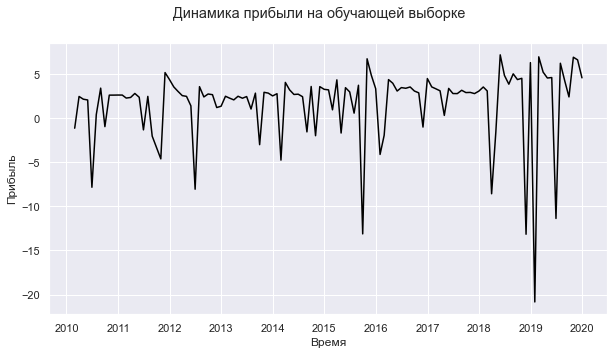

In [82]:
plt.figure(figsize = (10, 5))

plt.suptitle('Динамика прибыли на обучающей выборке')
plt.ylabel('Прибыль')
plt.xlabel('Время')

plt.plot(df2_train['Strategy'], color = 'black')

plt.grid(True)
plt.show()

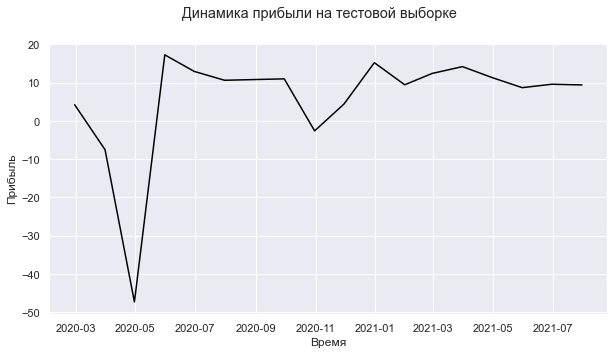

In [83]:
plt.figure(figsize = (10, 5))

plt.suptitle('Динамика прибыли на тестовой выборке')
plt.ylabel('Прибыль')
plt.xlabel('Время')

plt.plot(df2_test['Strategy'], color = 'black')

plt.grid(True)
plt.show()

Отношение накопленной доходности рассчитана, как отношение абсолютной прибыли к абсолютному значению просадки, так как начального капитала мы не имели и в данном случае показатель доходности не имеет смысла.

In [90]:
t = PrettyTable(['Выборка', 'Прибыль со стратегии', 'Коэффициент Шарпа', 'Отношение накопленной доходности к максимальной просадке'])
t.add_row(['Обучающая', round(df2_train['Strategy'].sum(), 3), round(sharpe_train, 3), round(df2_train['Strategy'].sum()/abs(drawdown_df2_train.min()), 3)])
t.add_row(['Тестовая', round(df2_test['Strategy'].sum(), 3), round(sharpe_test, 3), round(df2_test['Strategy'].sum()/abs(drawdown_df2_test.min()), 3)])
print(t)

+-----------+----------------------+-------------------+----------------------------------------------------------+
|  Выборка  | Прибыль со стратегии | Коэффициент Шарпа | Отношение накопленной доходности к максимальной просадке |
+-----------+----------------------+-------------------+----------------------------------------------------------+
| Обучающая |       202.922        |       0.948       |                          8.258                           |
|  Тестовая |        93.339        |       0.367       |                          12.251                          |
+-----------+----------------------+-------------------+----------------------------------------------------------+
